# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 13.0MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Mon Feb  1 01:51:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# data dir
data_dir = '/content/drive/MyDrive/Data/nlp'
os.listdir(data_dir)

['kowiki', 'ko_32000.model', 'ko_32000.vocab', '.ipynb_checkpoints', 'nsmc']

In [7]:
# quora dir
quora_dir = os.path.join(data_dir, 'quora')or
if not os.path.exists(quora_dir):
    os.makedirs(quora_dir)
os.listdir(quora_dir)

[]

# Vocabulary & config

In [8]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [9]:
n_vocab = len(vocab)  # number of vocabulary
n_seq_1 = 26  # number of sequence 1
n_seq_2 = 27  # number of sequence 2
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 다운로드
- https://github.com/songys/Question_pair

In [10]:
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv

--2021-02-01 02:06:09--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 608164 (594K) [text/plain]
Saving to: ‘kor_pair_train.csv’

kor_pair_train.csv  100%[===================>] 593.91K  --.-KB/s    in 0.03s   

2021-02-01 02:06:09 (19.8 MB/s) - ‘kor_pair_train.csv’ saved [608164/608164]

--2021-02-01 02:06:09--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52943 (52K) [text/pl

In [11]:
shutil.move('kor_pair_train.csv', os.path.join(quora_dir, 'kor_pair_train.csv'))
shutil.move('kor_Pair_test.csv', os.path.join(quora_dir, 'kor_Pair_test.csv'))
os.listdir(quora_dir)

['kor_pair_train.csv', 'kor_Pair_test.csv']

# 데이터 분석

In [12]:
# train data load
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [13]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


## Char

### question1

In [14]:
# char 길이 데이터
char_len = df_train['question1'].astype("str").apply(len)
char_len.head(10)

0    17
1    20
2    11
3    22
4    13
5    12
6     5
7    11
8    14
9    20
Name: question1, dtype: int64

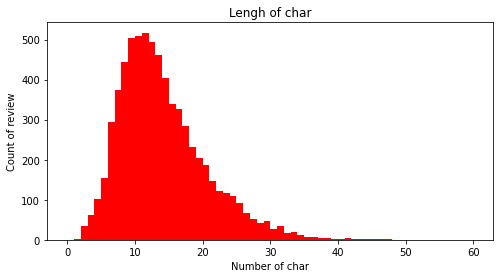

In [15]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=60, range=[0, 60], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [16]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      47
char 길이 최소:       1
char 길이 평균:      13.60
char 길이 표준편차:    6.40
char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    17.00
char IQR:           8.00
char MAX/100분위:   29.00


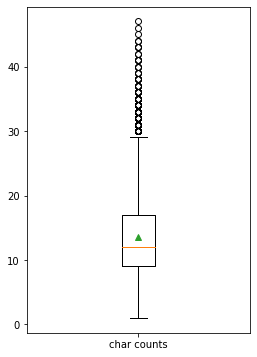

In [17]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

### question2

In [18]:
# char 길이 데이터
char_len = df_train['question2'].astype("str").apply(len)
char_len.head(10)

0     8
1    20
2    13
3     6
4    16
5    15
6    18
7    12
8     9
9     8
Name: question2, dtype: int64

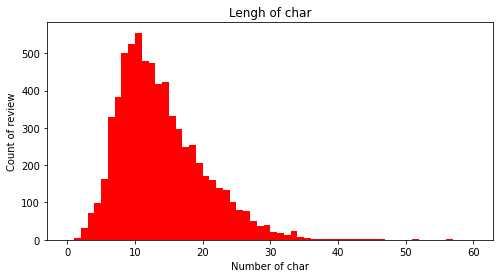

In [19]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=60, range=[0, 60], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [20]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 길이 최대:      56
char 길이 최소:       1
char 길이 평균:      13.30
char 길이 표준편차:    6.22
char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    17.00
char IQR:           8.00
char MAX/100분위:   29.00


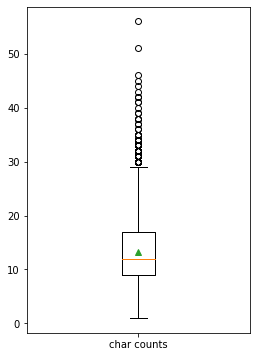

In [21]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

### question1

In [22]:
# word 길이 데이터
word_len = df_train['question1'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    4
1    5
2    2
3    6
4    3
5    3
6    2
7    3
8    3
9    5
Name: question1, dtype: int64

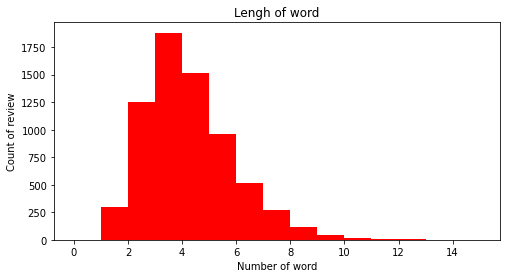

In [23]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=15, range=[0, 15], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [24]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      12
word 길이 최소:       1
word 길이 평균:       3.77
word 길이 표준편차:    1.67
word 25/100분위:     3.00
word 50/100분위:     4.00
word 75/100분위:     5.00
word IQR:           2.00
word MAX/100분위:    8.00


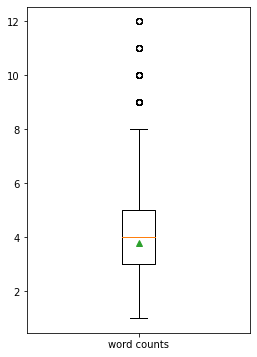

In [25]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

### question2

In [26]:
# word 길이 데이터
word_len = df_train['question2'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

0    2
1    5
2    3
3    1
4    5
5    3
6    5
7    3
8    2
9    2
Name: question2, dtype: int64

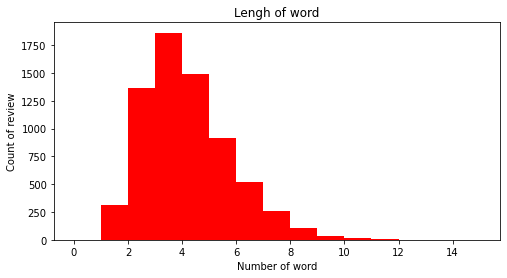

In [27]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=15, range=[0, 15], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [28]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

word 길이 최대:      15
word 길이 최소:       1
word 길이 평균:       3.69
word 길이 표준편차:    1.63
word 25/100분위:     3.00
word 50/100분위:     3.00
word 75/100분위:     5.00
word IQR:           2.00
word MAX/100분위:    8.00


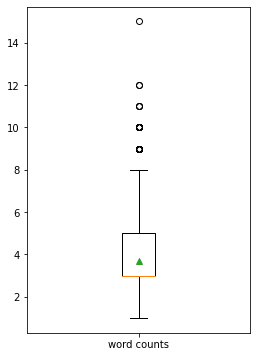

In [29]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

### question1

In [30]:
# word 길이 데이터
spm_len = df_train['question1'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0     7
1    11
2     8
3    13
4     8
5     5
6     4
7     7
8     9
9    10
Name: question1, dtype: int64

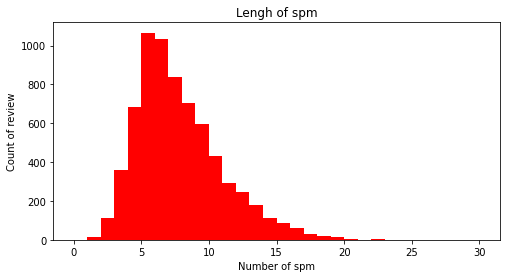

In [31]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=30, range=[0, 30], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [32]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      26
spm 길이 최소:       1
spm 길이 평균:       7.33
spm 길이 표준편차:    3.19
spm 25/100분위:     5.00
spm 50/100분위:     7.00
spm 75/100분위:     9.00
spm IQR:           4.00
spm MAX/100분위:   15.00


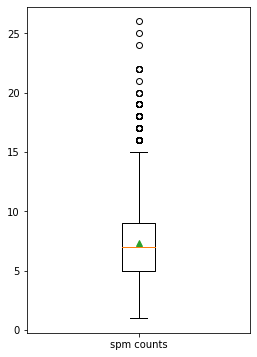

In [33]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

### question2

In [34]:
# word 길이 데이터
spm_len = df_train['question2'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

0     5
1     9
2     7
3     7
4    10
5    11
6    10
7     8
8     6
9     6
Name: question2, dtype: int64

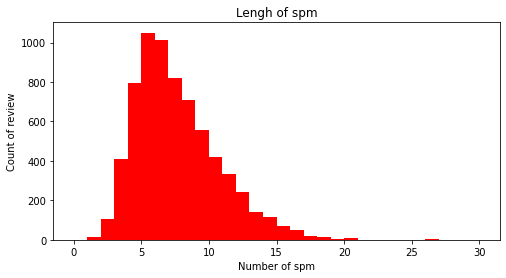

In [35]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=30, range=[0, 30], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [36]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

spm 길이 최대:      26
spm 길이 최소:       1
spm 길이 평균:       7.16
spm 길이 표준편차:    3.11
spm 25/100분위:     5.00
spm 50/100분위:     7.00
spm 75/100분위:     9.00
spm IQR:           4.00
spm MAX/100분위:   15.00


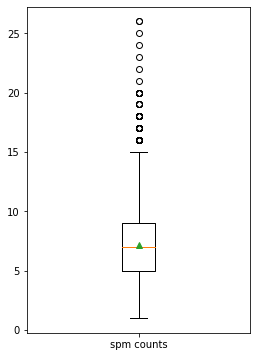

In [37]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Label

In [38]:
df_train['is_duplicate'].value_counts()

0    4750
1    2138
Name: is_duplicate, dtype: int64

In [39]:
# label count
print(f"같은 질문 개수: {df_train['is_duplicate'].value_counts()[0]}")
print(f"다른 질문 개수: {df_train['is_duplicate'].value_counts()[1]}")

같은 질문 개수: 4750
다른 질문 개수: 2138


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


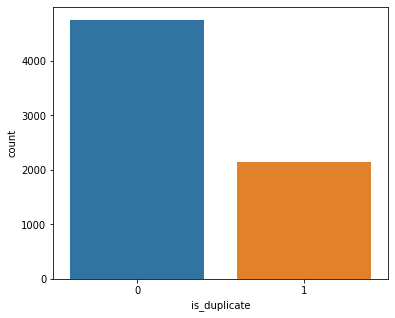

In [40]:
# label counter plot
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 5)
# https://seaborn.pydata.org/
subplt = sns.countplot(df_train['is_duplicate'])

## Word Cloud

In [ ]:
[1, 2, 3] + [4, 5, 6]

In [42]:
# data 합치기
train_set = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
train_set.head(10)

0         1000일 만난 여자친구와 이별
1      10년 연애사 되돌아보니 다 부질없네
2               10년만나다 헤어지네
3    10월의 마지막밤 . 더 보고싶네 그사람
4             14년의 기나긴 이야기.
5              15년만에 쓰는 편지.
6                     1년 반.
7               1년동거 끝에 헤어짐
8            1년만에 다시헤어지게 됐네
9      1년을 넘게 만났는데 어떻게 이럽니까
dtype: object

In [43]:
# train review documents
train_review = [review for review in train_set if type(review) is str]
train_review[:10]

['1000일 만난 여자친구와 이별',
 '10년 연애사 되돌아보니 다 부질없네',
 '10년만나다 헤어지네',
 '10월의 마지막밤 . 더 보고싶네 그사람',
 '14년의 기나긴 이야기.',
 '15년만에 쓰는 편지.',
 '1년 반.',
 '1년동거 끝에 헤어짐',
 '1년만에 다시헤어지게 됐네',
 '1년을 넘게 만났는데 어떻게 이럽니까']

In [44]:
' '.join(train_review[:10])

'1000일 만난 여자친구와 이별 10년 연애사 되돌아보니 다 부질없네 10년만나다 헤어지네 10월의 마지막밤 . 더 보고싶네 그사람 14년의 기나긴 이야기. 15년만에 쓰는 편지. 1년 반. 1년동거 끝에 헤어짐 1년만에 다시헤어지게 됐네 1년을 넘게 만났는데 어떻게 이럽니까'

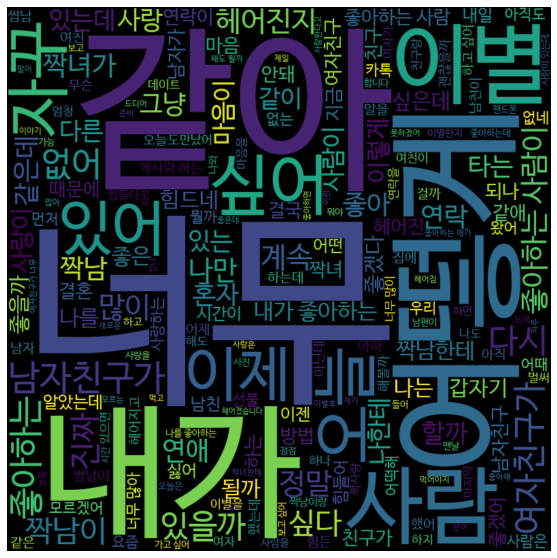

In [46]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 모델링

In [48]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '나는 오늘 우울해'],
    ['나는 오늘 행복해', '나는 오늘 즐거워'],
]

# 출력 정답
labels = [0, 1]  # 같음(1), 다름(0)

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    print(pair)
    for sentence in pair:
        print(sentence)
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

In [50]:
# 학습용 입력 데이터 생성
train_inputs_1, train_inputs_2 = [], []
for pair in sentences:
    train_inputs_1.append([word_to_id[word] for word in pair[0].split()])
    train_inputs_2.append([word_to_id[word] for word in pair[1].split()])

# train label
train_labels = labels

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs_1:
    row += [0] * (4 - len(row))

# 문장의 길이를 모두 동일하게 변경 (최대길이 3)
for row in train_inputs_2:
    row += [0] * (3 - len(row))

# train inputs을 numpy array로 변환
train_inputs_1 = np.array(train_inputs_1)
train_inputs_2 = np.array(train_inputs_2)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs_1, train_inputs_2, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 7, 0]]), array([[2, 3, 6],
        [2, 3, 8]]), array([0, 1]))

In [51]:
# embedding 생성
embedding = tf.keras.layers.Embedding(len(word_to_id), 5)

In [ ]:
# word embedding
hidden_1 = embedding(train_inputs_1)  # (bs, n_seq_1, 5)
hidden_2 = embedding(train_inputs_2)  # (bs, n_seq_2, 5)
hidden_1, hidden_2

In [ ]:
# RNN, CNN 등

In [ ]:
# sentence embedding
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool_1 = pool(hidden_1)  # (bs, 5)
hidden_pool_2 = pool(hidden_2)  # (bs, 5)
hidden_pool_1, hidden_pool_2

In [55]:
# distance abs
K.abs(hidden_pool_1 - hidden_pool_2)

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.        , 0.        , 0.01867396, 0.        , 0.00437939],
       [0.        , 0.        , 0.02559464, 0.        , 0.00407587]],
      dtype=float32)>

In [58]:
# manhattan distance abs
distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
distance

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.02305335, 0.02967051], dtype=float32)>

In [59]:
# output value
output = K.exp(-distance)
output

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9772103, 0.9707653], dtype=float32)>

In [ ]:
# Generate linearly spaced vector
distance = np.linspace(0, 10, 100)
distance

In [ ]:
# draw plot
plt.plot(distance, K.exp(-distance))
plt.title('malstm')
plt.show()

In [62]:
def build_model(n_vocab, d_model, n_seq_1, n_seq_2):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq_1: 문장 1 길이 (단어 수)
    :param n_seq_2: 문장 2 길이 (단어 수)
    """
    inputs_1 = tf.keras.layers.Input((n_seq_1,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((n_seq_2,))  # (bs, n_seq_2)
    ##########################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)

    # RNN, CNN, Dense
    
    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool_1 = pool(hidden_1)  # (bs, d_model)
    hidden_pool_2 = pool(hidden_2)  # (bs, d_model)

    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_pool_1 - hidden_pool_2), axis=-1)
    outputs = K.exp(-distance)
    ##########################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=outputs)
    return model

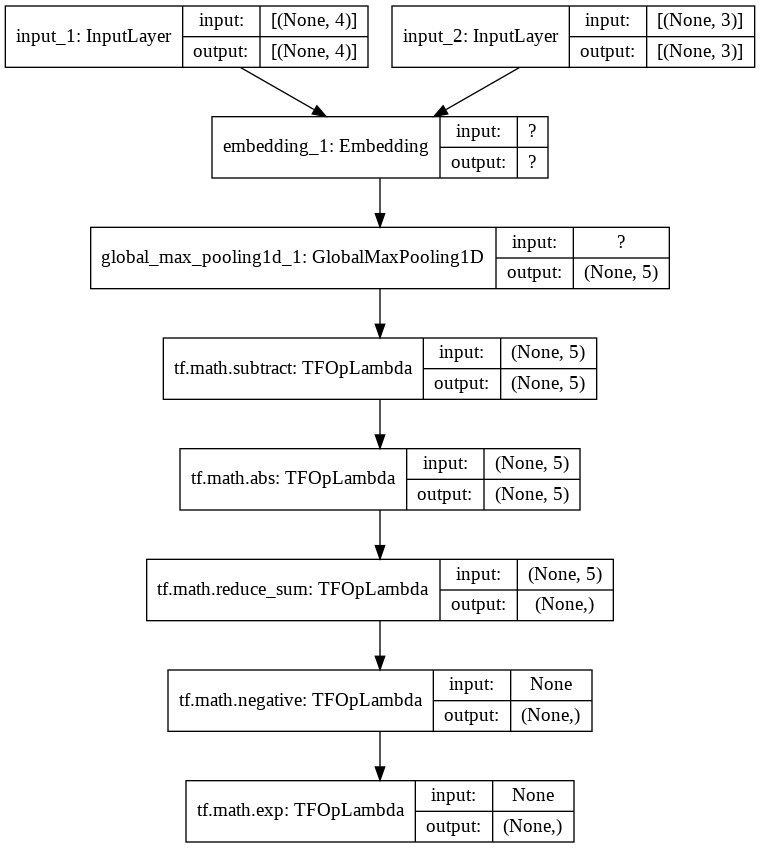

In [63]:
# 모델 생성
model = build_model(len(word_to_id), 5, 4, 3)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Sample Data Project

## Data


In [64]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

In [67]:
df_test.dropna()

,test_id,question1,question2,is_duplicate,Unnamed: 4
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0


In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

In [ ]:
df_test = df_test.dropna()
df_test

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

In [ ]:
# 랜덤하게 10개만 확인
df_test = df_test.sample(10)
df_test

In [84]:
def load_data(df, n_seq_1, n_seq_2):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_seq_1: number of sequence 1
    :param n_seq_2: number of sequence 2
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    inputs_1 = np.zeros((len(df), n_seq_1)).astype(np.int32)
    inputs_2 = np.zeros((len(df), n_seq_2)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        print()
        #################################
        is_duplicate = row['is_duplicate']
        question1 = row['question1']
        question2 = row['question2']
        print(is_duplicate, '/', question1, '/', question2)
        # 문장을 token으로 변환
        tokens_1 = vocab.encode_as_pieces(question1)
        print(len(tokens_1), ':', tokens_1)
        tokens_2 = vocab.encode_as_pieces(question2)
        print(len(tokens_2), ':', tokens_2)
        # 문장을 id로 변환
        token_ids_1 = vocab.encode_as_ids(question1)
        print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = vocab.encode_as_ids(question2)
        print(len(token_ids_2), ':', token_ids_2)
        # 길이가 길면 길이를 줄임
        token_ids_1 = token_ids_1[:n_seq_1]
        print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = token_ids_2[:n_seq_2]
        print(len(token_ids_2), ':', token_ids_2)
        # 길이가 짧으면 늘려줌 (pad(0))
        token_ids_1 += [0] * (n_seq_1 - len(token_ids_1))
        print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 += [0] * (n_seq_2 - len(token_ids_2))
        print(len(token_ids_2), ':', token_ids_2)

        labels[index] = 1 - is_duplicate  # 0 -> 1, 1 -> 0
        inputs_1[index] = token_ids_1
        inputs_2[index] = token_ids_2
        index += 1
        #################################
    return inputs_1, inputs_2, labels

In [86]:
# train data 생성
train_inputs_1, train_inputs_2, train_labels = load_data(df_train, n_seq_1, n_seq_2)
train_inputs_1, train_inputs_2, train_labels


0 / 어이가 없어서 / 어이없어
4 : ['▁어', '이', '가', '▁없어서']
4 : ['▁어', '이', '없', '어']
4 : [492, 17, 19, 11579]
4 : [492, 17, 11654, 110]
4 : [492, 17, 19, 11579]
4 : [492, 17, 11654, 110]
26 : [492, 17, 19, 11579, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
27 : [492, 17, 11654, 110, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 / 결국 헤어짐이 찾아오네 / 결혼 가치관 때문에 헤어졌네.
6 : ['▁결국', '▁헤어', '짐', '이', '▁찾아오', '네']
7 : ['▁결혼', '▁가치관', '▁때문에', '▁헤어', '졌', '네', '.']
6 : [493, 10316, 4418, 17, 22564, 343]
7 : [1381, 23399, 135, 10316, 14916, 343, 7]
6 : [493, 10316, 4418, 17, 22564, 343]
7 : [1381, 23399, 135, 10316, 14916, 343, 7]
26 : [493, 10316, 4418, 17, 22564, 343, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
27 : [1381, 23399, 135, 10316, 14916, 343, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 / 사랑을 믿으세요? / 사랑이 끝나고 할 일?
5 : ['▁사랑을', '▁믿', '으', '세요', '?']
6 : ['▁사랑', '이', '▁끝나고', '▁할', '▁일', '?']
5 : [5775, 7830, 3481, 15

(array([[  492,    17,    19, 11579,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  493, 10316,  4418,    17, 22564,   343,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 5775,  7830,  3481, 15319,  1860,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [13454,  1183,  8236,    72,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 2971,    19,  2591,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

In [87]:
# test data 생성
test_inputs_1, test_inputs_2, test_labels = load_data(df_test, n_seq_1, n_seq_2)
test_inputs_1, test_inputs_2, test_labels


1 / 노래 불러줘 / 웃긴게 장난없음
3 : ['▁노래', '▁불러', '줘']
6 : ['▁웃', '긴', '게', '▁장난', '없', '음']
3 : [1186, 2887, 14904]
6 : [8196, 1994, 128, 18006, 11654, 583]
3 : [1186, 2887, 14904]
6 : [8196, 1994, 128, 18006, 11654, 583]
26 : [1186, 2887, 14904, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
27 : [8196, 1994, 128, 18006, 11654, 583, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 / 오늘 화장 좀 잘된다 / 부모님이 허락 안해주셔
5 : ['▁오늘', '▁화장', '▁좀', '▁잘', '된다']
7 : ['▁부모님', '이', '▁허락', '▁안', '해', '주', '셔']
5 : [9676, 16081, 3760, 441, 309]
7 : [10676, 17, 5235, 295, 61, 92, 2548]
5 : [9676, 16081, 3760, 441, 309]
7 : [10676, 17, 5235, 295, 61, 92, 2548]
26 : [9676, 16081, 3760, 441, 309, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
27 : [10676, 17, 5235, 295, 61, 92, 2548, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1 / 뭐 이렇게 끝나냐 / 마지막 문자 보냄
4 : ['▁뭐', '▁이렇게', '▁끝나', '냐']
4 : ['▁마지막', '▁문자', '▁보', '냄']
4 : [19999, 1640, 9737, 1969]
4 

(array([[ 1186,  2887, 14904,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [ 9676, 16081,  3760,   441,   309,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [19999,  1640,  9737,  1969,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  441, 16935, 13549,  6452,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0],
        [  507,   188,   264,    70, 25523, 13865,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0, 

## 학습

In [94]:
len(vocab), d_model, n_seq_1, n_seq_2

(32007, 256, 26, 27)

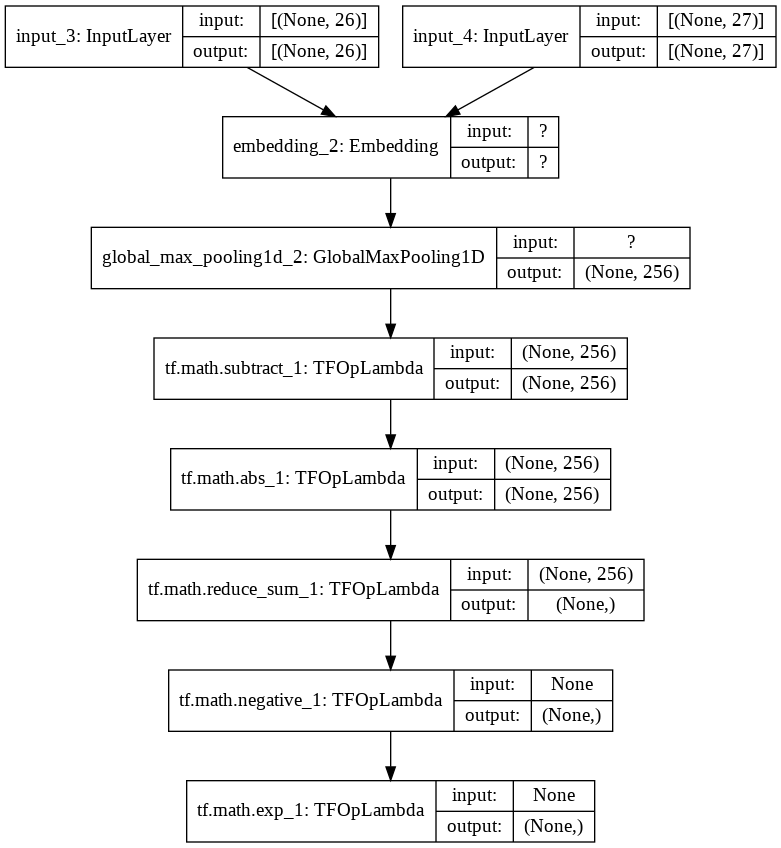

In [88]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [89]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

In [90]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=50)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(quora_dir, 'stub.hdf5'),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(quora_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_inputs_1, train_inputs_2),
                    train_labels,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

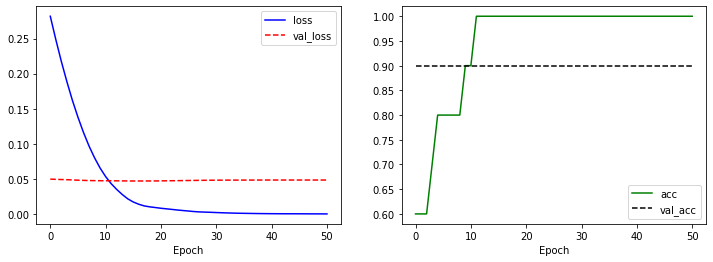

In [92]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='acc')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [104]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# train weight로 초기화
model.load_weights(os.path.join(quora_dir, 'stub.hdf5'))

In [105]:
# 예측
logits = model.predict((test_inputs_1, test_inputs_2))
logits

array([0.02530433, 0.05701054, 0.02742256, 0.03443673, 0.02164804,
       0.0667263 , 0.32108283, 0.0846392 , 0.11033073, 0.08364752],
      dtype=float32)

In [101]:
# 0.5를 기준으로 (0, 1) 결정
test_preds = (0.5 < logits).astype(np.int)
test_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [106]:
# confusion matrix 계산
confusion_matrix = np.zeros((2, 2)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[9, 0],
       [1, 0]])

In [107]:
# score 계산
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max(tp + fp, 1)
print(f'precision: {precision}')
recall = (tp) / max(tp + fn, 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max(precision + recall, 1)
print(f'f1: {f1}')

accuracy: 0.9
precision: 0.0
recall: 0.0
f1: 0.0


In [113]:
def do_predict(model, n_seq_1, string1, n_seq_2, string2):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq_1: 입력 개수 1
    :param string1: 입력 문자열 1
    :param n_seq_1: 입력 개수 2
    :param string2: 입력 문자열 2
    """
    ###############################
    # token 생성: <string 1 tokens>, [PAD] tokens
    token1 = vocab.encode_as_ids(string1)
    token1 = token1[:n_seq_1]
    token1 += [0] * (n_seq_1 - len(token1))
    print(token1)

    # token 생성: <string 2 tokens>, [PAD] tokens
    token2 = vocab.encode_as_ids(string2)
    token2 = token2[:n_seq_2]
    token2 += [0] * (n_seq_2 - len(token2))
    print(token2)

    y_pred = model.predict((np.array([token1]), np.array([token2])))

    return "같음" if y_pred[0] > 0.5 else "다름"
    ###############################

In [114]:
string1 = '나는 오늘 기분이 좋아'
string2 = '나는 오늘 우울해'
do_predict(model, n_seq_1, string1, n_seq_2, string2)

[3872, 9676, 16056, 17, 2795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3872, 9676, 22428, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


'다름'

In [115]:
while True:
    print("string #1 > ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("string #2 > ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    print(f"output > {do_predict(model, n_seq_1, string1, n_seq_2, string2)}")

string #1 > 오늘은 기분이 좋아
string #2 > 오늘은 기분이 우울해
[9676, 18, 16056, 17, 2795, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[9676, 18, 16056, 17, 22428, 61, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
output > 다름
string #1 > 


# All Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(quora_dir, 'kor_pair_train.csv'), delimiter=',')
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
df_test = pd.read_csv(os.path.join(quora_dir, 'kor_Pair_test.csv'), delimiter=',')
df_test

In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

In [ ]:
df_test = df_test.dropna()
df_test

In [ ]:
def load_data(df, n_seq_1, n_seq_2):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_seq_1: number of sequence 1
    :param n_seq_2: number of sequence 2
    :return inputs_1: input data 1
    :return inputs_2: input data 2
    :return labels: label data
    """
    inputs_1 = np.zeros((len(df), n_seq_1)).astype(np.int32)
    inputs_2 = np.zeros((len(df), n_seq_2)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        is_duplicate = row['is_duplicate']
        question1 = row['question1']
        question2 = row['question2']
        # print(is_duplicate, question1, question2)

        tokens_1 = vocab.encode_as_pieces(question1)
        # print(len(tokens_1), ':', tokens_1)
        tokens_2 = vocab.encode_as_pieces(question2)
        # print(len(tokens_2), ':', tokens_2)

        token_ids_1 = vocab.encode_as_ids(question1)
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = vocab.encode_as_ids(question2)
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 = token_ids_1[:n_seq_1]
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 = token_ids_2[:n_seq_2]
        # print(len(token_ids_2), ':', token_ids_2)

        token_ids_1 += [0] * (n_seq_1 - len(token_ids_1))
        # print(len(token_ids_1), ':', token_ids_1)
        token_ids_2 += [0] * (n_seq_2 - len(token_ids_2))
        # print(len(token_ids_2), ':', token_ids_2)

        labels[index] = 1 - is_duplicate  # 0 -> 1, 1 -> 0
        inputs_1[index] = token_ids_1
        inputs_2[index] = token_ids_2
        index += 1
    return inputs_1, inputs_2, labels

In [ ]:
# train data 생성
train_inputs_1, train_inputs_2, train_labels = load_data(df_train, n_seq_1, n_seq_2)
train_inputs_1, train_inputs_2, train_labels

In [ ]:
# test data 생성
test_inputs_1, test_inputs_2, test_labels = load_data(df_test, n_seq_1, n_seq_2)
test_inputs_1, test_inputs_2, test_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['binary_accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(quora_dir, 'stub.hdf5'),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(quora_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_inputs_1, train_inputs_2),
                    train_labels,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

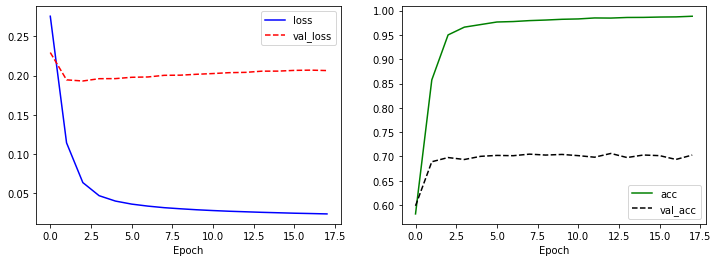

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='acc')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq_1, n_seq_2)
# train weight로 초기화
model.load_weights(os.path.join(quora_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict((test_inputs_1, test_inputs_2))
logits

In [ ]:
# 0.5를 기준으로 (0, 1) 결정
test_preds = (0.5 < logits).astype(np.int)
test_preds

In [ ]:
# confusion matrix 계산
confusion_matrix = np.zeros((2, 2)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

In [ ]:
# score 계산
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max(tp + tn + fp + fn, 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max(tp + fp, 1)
print(f'precision: {precision}')
recall = (tp) / max(tp + fn, 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max(precision + recall, 1)
print(f'f1: {f1}')

In [ ]:
def do_predict(model, n_seq_1, string1, n_seq_2, string2):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq_1: 입력 개수 1
    :param string1: 입력 문자열 1
    :param n_seq_1: 입력 개수 3
    :param string2: 입력 문자열 2
    """
    # token 생성: <string 1 tokens>, [PAD] tokens
    token1 = vocab.encode_as_ids(string1)[:n_seq_1]
    token1 += [0] * (n_seq_1 - len(token1))

    # token 생성: <string 2 tokens>, [PAD] tokens
    token2 = vocab.encode_as_ids(string2)[:n_seq_2]
    token2 += [0] * (n_seq_2 - len(token2))

    y_pred = model.predict((np.array([token1]), np.array([token2])))

    return "같음" if y_pred[0] > 0.5 else "다름"

In [ ]:
while True:
    print("string #1 > ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("string #2 > ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    print(f"output > {do_predict(model, n_seq_1, string1, n_seq_2, string2)}")